# SNS 트렌드 분석 베이스라인
## 1) 불용어 처리 
## 2) 품사태깅 
## 3) 감성분류 
## 4) 워드 클라우드 생성 

In [1]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd 

In [4]:
import os
os.chdir('/content/drive')


# 1) 불용어 처리

In [6]:
# 불용어 처리

stopwords=open("/content/drive/MyDrive/한국어불용어100_.txt",'r',encoding='UTF8')
stop=stopwords.read()
stop=stop.split()
stop_list=[stop[i] for i in range(len(stop)) if i%3==0 ]

#  <추가 불용어 처리>
#stop_list=stop_list+['.','!','ㅠ','?','%','vs','ㅊ',',','/',''  ]# <- 필요없는 단어    

In [7]:
# 불용어 처리 함수
def stopword(word_tokenize):
  return [w for w in word_tokenize if w not in stop_list]

# 2) 품사태깅 함수

In [8]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 71.7 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [9]:
!pip install collection

  Created wheel for collection: filename=collection-0.1.6-py3-none-any.whl size=5117 sha256=3da76cf81b9fe539a11b34f3b9b699fbbb13058dba33d363de69f58b0d624c55
  Stored in directory: /root/.cache/pip/wheels/45/ed/3c/29a1c0600bb908a2e7421dc3a3775cbaed434a71b4ed93a439
Successfully built collection


In [12]:
!pip install matplotlib

In [13]:
!pip install wordcloud

In [36]:
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd


In [25]:
# 품사태깅 함수 
# 인풋 : 데이터 프레임 형태로 행별로 글들이 담겨있는 형태

# 병렬처리 적용하기*****************************************************************************

def part_tagging(data):
  from konlpy.tag import Okt

  Okt = Okt()
  morphs=[]

  for sentence in data:
    for x in sentence:
      morphs.append(Okt.pos(x))

  return morphs # 품사 태깅해서 하나의 리스트형태로 반환

# 3) 감성 분류

# 4) 워드클라우드 생성

In [45]:
# 리스트 형태로 받아서 워드 클라우드, 단어별 개수 출력

def cloud(data): 
  # 단어별 개수세기 
  counts = Counter(data)
  tags = counts.most_common(40)

  # 워드 클라우드 생성
  wc = WordCloud(font_path="/content/drive/MyDrive/NanumGothic.ttf",background_color="white", max_font_size=60)
  cloud = wc.generate_from_frequencies(dict(tags))
  return cloud, pd.DataFrame(tags)

In [18]:
# 통합 함수 프로토 타입 
def word_cloud(data):
  from konlpy.tag import Okt

  Okt = Okt()
  # 인덱싱 reset, na값 제거 
  data=data.reset_index(drop=True).dropna(axis=0)

 
  token_list =[]
  # 문장을 토큰화 하고 불용어 처리 
  for i in data:
    token_list.append(stopword(word_tokenize(i)))

  # 품사 태깅
  morphs=[]

  for sentence in token_list:
    for i in range(len(sentence)):
      morphs.append(Okt.pos(sentence[i]))

  ## 명사길이가 1이상인 것만 추가
  noun_list=[]
  for sentence in morphs:
    for word, tag in sentence :
      if tag in ['Noun'] and len(word) > 1:
        noun_list.append(word)

  # 단어별 개수세기 
  counts = Counter(noun_list)
  tags = counts.most_common(40)

  # 워드 클라우드 생성
  wc = WordCloud(font_path="/content/drive/MyDrive/NanumGothic.ttf",background_color="white", max_font_size=60)
  cloud = wc.generate_from_frequencies(dict(tags))
  return cloud
  #cloud.to_file('/content/drive/MyDrive/wheelchair_travel.jpg')
  #pd.DataFrame(tags)[0:10]

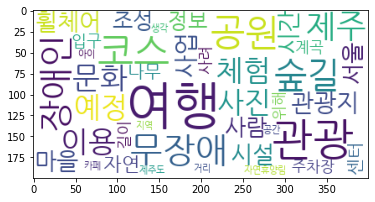

In [22]:
# 프로토 타입 함수 테스트 
import pandas as pd

sample = pd.read_csv("/content/drive/MyDrive/sns_crawling.csv", encoding = "utf-8")


plt.imshow(word_cloud(sample[(sample['keyword']=='무장애여행')]['content']))

In [46]:
# 품사구분, 기능함수화한 함수 

# 명사= 'Noun', 동사= 'Verb', 형용사 = 'Adjective'
# new_word_cloud(data,'Noun')
def poomsa_word_cloud(data,poomsa):

  # 인덱싱 reset, na값 제거 
  data=data.reset_index(drop=True).dropna(axis=0)

  # 문장을 토큰화 하고 불용어 처리 
  token_list =[stopword(word_tokenize(i)) for x in data ]

  # 품사 태깅 -> Okt에서 800 자 제한이 있어 800자씩 나누어 품사처리후 morphs에 append
  morphs=[part_tagging(token_list[i*800:(i+1)*800]) for i in range((len(token_list)//800)-1) ]

  ## 설정한 품사 길이가 1이상인 것만 추가
  noun_list=[ word for sentence in morphs  for word, tag in sentence  if tag in [poomsa] and len(word) > 1 ]

  # 클라우드, 단어별 개수 반환
  return cloud(noun_list)

In [ ]:
# 프로토 타입 함수 테스트 
import pandas as pd

sample = pd.read_csv("/content/drive/MyDrive/sns_crawling.csv", encoding = "utf-8")

# 동사, 개수 출력

word_image, word_count = poomsa_word_cloud(sample[(sample['keyword']=='무장애여행')]['content'],'Verb' )

# 워드 클라우드 이미지
plt.imshow(word_image)

# 단어별 빈도수 출력 
word_count